#Description:
In this notebook, we will build a movie recommeder system that gets the movie name that you like as input and select a few movies that you may also like. We will use collaborative filtering and also try to benefit from metadata (movie descriptions)

#Part 1: Data Preparation


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.neighbors import NearestNeighbors
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!ls "/content/drive/My Drive/Colab Notebooks/datasets/movies"

Mounted at /content/drive
keywords.csv  links.csv  movies_metadata.csv  ratings.csv


First, we are getting rating data file from my Google **Drive**
Same dataset can be found at https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset




In [ ]:
df = pd.read_csv("drive/My Drive/Colab Notebooks/datasets/movies/ratings.csv", on_bad_lines='skip')
df.drop(['timestamp'], axis=1, inplace=True)
df['movieId'] = df['movieId'].astype(int, errors='ignore')

print(f'Unique Values for Each Column: \n{df.apply(pd.Series.nunique)} \n')
print(f'There are {len(df)} ratings in total \n')
df.head(2)

Unique Values for Each Column: 
userId     270896
movieId     45115
rating         10
dtype: int64 

There are 26024289 ratings in total 



,userId,movieId,rating
0,1,110,1.0
1,1,147,4.5


Using histogram to (i)check distribution of ratings and (ii)being sure they are all between 0.5-5

Mean value is 3.53


<Axes: title={'center': 'Rating Frequency Chart'}, ylabel='Frequency'>

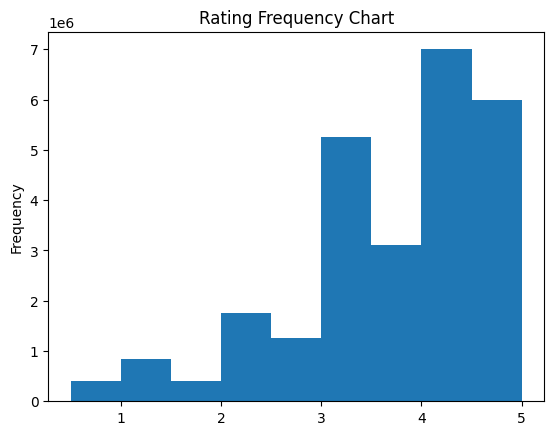

In [ ]:
df_mean = df['rating'].mean()
print(f'Mean value is {df_mean:.2f}')
df['rating'].plot(kind='hist', bins=9, title='Rating Frequency Chart')

For movie_id and original_title matching, we need to combine metadata file and links file

In [ ]:
#Reading and preparing metadata file
df_meta = pd.read_csv("drive/My Drive/Colab Notebooks/datasets/movies/movies_metadata.csv",
                      on_bad_lines='skip')
#df_meta.drop_duplicates(subset=['id'], inplace=True)
df_meta.rename(columns={'id': 'tmdbId'}, inplace=True)
df_meta["tmdbId"] =pd.to_numeric(df_meta['tmdbId'], errors='coerce',downcast="integer")

#Taking movieId and tmdbId(id column at metadata) from links file
df_links = pd.read_csv("drive/My Drive/Colab Notebooks/datasets/movies/links.csv",
                      on_bad_lines='skip')
df_links = df_links[['movieId', 'tmdbId']]
df_links.drop_duplicates(subset=['tmdbId'], inplace=True)

#Taking keywords from keywords file
df_keywords = pd.read_csv("drive/My Drive/Colab Notebooks/datasets/movies/keywords.csv",
                      on_bad_lines='skip')
df_keywords.rename(columns={'id': 'tmdbId'}, inplace=True)

#Merging DataFrames, keeping only movieId and title, removing bad lines
df_meta = pd.merge(df_links, df_meta, how='inner', on='tmdbId')
df_meta["movieId"] =pd.to_numeric(df_meta['movieId'], errors='coerce',downcast="integer")
df_meta.dropna(subset=["movieId"],inplace=True)
df_meta = pd.merge(df_meta, df_keywords, how='left', on='tmdbId')
df_meta.head(2)

,movieId,tmdbId,adult,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,keywords
0,1,862.0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,tt0114709,en,Toy Story,...,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,2,8844.0,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,tt0113497,en,Jumanji,...,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."


Description of important columns:

* movieId: the unique id for each movie in this dataset

* budget - the budget of the movie, contains many "0" values - not reliable

* original_language - the language that the movie was made

* original_title - the original name of the movie

* overview - a short summary of the movie

* revenue - the worldwide generated revenue

* runtime - the length of the movie in minutes

* votecount - the total amount of votes that the movie received in this dataset

* keywords - tags for the movie, each tag also has an id


In [ ]:
df_meta = df_meta[['movieId', 'original_language', 'original_title', 'overview', 'revenue', 'runtime', 'keywords']]
df_meta.head(2)

,movieId,original_language,original_title,overview,revenue,runtime,keywords
0,1,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",373554033.0,81.0,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,2,en,Jumanji,When siblings Judy and Peter discover an encha...,262797249.0,104.0,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."


Merging both dataframes to have names

Dropna helps to drop rows with no movie name as (i) Non-English movie, (ii) Bad formatting

In [ ]:
df = pd.merge(df, df_meta, on="movieId",how="inner")
print(f'{df.info()}\n')
print(f'{df.head(2)}')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26025228 entries, 0 to 26025227
Data columns (total 9 columns):
 #   Column             Dtype  
---  ------             -----  
 0   userId             int64  
 1   movieId            int64  
 2   rating             float64
 3   original_language  object 
 4   original_title     object 
 5   overview           object 
 6   revenue            float64
 7   runtime            float64
 8   keywords           object 
dtypes: float64(3), int64(2), object(4)
memory usage: 1.9+ GB
None

   userId  movieId  rating original_language original_title  \
0       1      110     1.0                en     Braveheart   
1      11      110     3.5                en     Braveheart   

                                            overview      revenue  runtime  \
0  Enraged at the slaughter of Murron, his new br...  210000000.0    177.0   
1  Enraged at the slaughter of Murron, his new br...  210000000.0    177.0   

                                         

The resulting matrix will be sparse

However, to be sure that (i) the matrix will not be too sparse, (ii) the computation is fast.

We can (i)eliminate unpopular movies, (ii)non-English movies, and (iii)only keep frequent voters

In [ ]:
df.drop(df[df['original_language'] != 'en'].index, inplace=True)

user_groupby = pd.Series(Counter(df['userId']))
freq_voters = user_groupby.loc[lambda x : x > 150]
print(f'In total, we will consider {freq_voters.size} voters as they voted for more than 150 movies')

movies_groupby = pd.Series(Counter(df['movieId']))
popular_movies = movies_groupby.loc[lambda x : x > 1000]
print(f'In total, we will consider {popular_movies.size} movies as they are voted by  more than 1000 users')

freq_voters = np.array(freq_voters.index)
popular_movies = np.array(popular_movies.index)

In total, we will consider 41419 voters as they voted for more than 150 movies
In total, we will consider 3476 movies as they are voted by  more than 1000 users


In [ ]:
df = df[df['userId'].isin(freq_voters)]
df = df[df['movieId'].isin(popular_movies)]
df.dropna(inplace=True)
print(f'{df.info()}\n')
print(f'{df.head(2)}')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14315076 entries, 1 to 25344669
Data columns (total 9 columns):
 #   Column             Dtype  
---  ------             -----  
 0   userId             int64  
 1   movieId            int64  
 2   rating             float64
 3   original_language  object 
 4   original_title     object 
 5   overview           object 
 6   revenue            float64
 7   runtime            float64
 8   keywords           object 
dtypes: float64(3), int64(2), object(4)
memory usage: 1.1+ GB
None

   userId  movieId  rating original_language original_title  \
1      11      110     3.5                en     Braveheart   
3      24      110     5.0                en     Braveheart   

                                            overview      revenue  runtime  \
1  Enraged at the slaughter of Murron, his new br...  210000000.0    177.0   
3  Enraged at the slaughter of Murron, his new br...  210000000.0    177.0   

                                         

#Part 2: Collaborative Filtering

We prepared our dataset in the previous step and df DataFrame contains all the required data for our study. In this step, we will use item-based collaborative filtering - using user ratings to find similar movies

Creating a rating matrix, rows are users' ratings and columns are movies.
We can expect a sparse matrix

In [ ]:
df_matrix =  df[['userId', 'original_title', 'rating']]
rating_matrix = df_matrix.pivot_table(index='original_title',  columns='userId', values='rating')
rating_matrix.info()
print(f'{rating_matrix.info()}\n')


<class 'pandas.core.frame.DataFrame'>
Index: 3417 entries, (500) Days of Summer to Æon Flux
Columns: 41419 entries, 11 to 270896
dtypes: float64(41419)
memory usage: 1.1+ GB
<class 'pandas.core.frame.DataFrame'>
Index: 3417 entries, (500) Days of Summer to Æon Flux
Columns: 41419 entries, 11 to 270896
dtypes: float64(41419)
memory usage: 1.1+ GB
None



We need to fill each row, cannot keep Nan

There are several alternatives on this step, I have chosen filling with 0 and create a sparse matrix. In other instances, such as reducing dimensionality using SVD, filling with row averages also yield good result.

In [ ]:
rating_matrix_filled = rating_matrix.apply(lambda row: row.fillna(0), axis=1)
rating_matrix_filled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3417 entries, (500) Days of Summer to Æon Flux
Columns: 41419 entries, 11 to 270896
dtypes: float64(41419)
memory usage: 1.1+ GB


For the recommendation system, as the dimensionality of this problem is reasonable, I will use KNN, which is highly flexible. If the dimensionality was larger (in case user-based filtering), SVD could be employed.

Tried ecludian distance metric, but cosine similarity is working slightly better.


In [ ]:
#Training KNN model
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=2)
knn.fit(rating_matrix_filled)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=2, n_neighbors=20)

In [ ]:
def movieRecommender(movie_name, knn, matrix):
  try:
    dist, idx = knn.kneighbors(matrix.loc[movie_name].values.reshape(1,-1),n_neighbors=20)
    print(f'For your selection of {movie_name}, I will recommend \n')
    for i in range(1, len(dist.flatten())):
      movie_name = matrix.index[idx.flatten()[i]]
      print(f'{i}- {movie_name}, distance is {dist.flatten()[i]:.3f}')
  except:
    print(f'The movie {movie_name} is not in our database. \n Please note that our database contains only popular movies up until mid 2017.')


We will try to use the recommender for an example movie:

In [ ]:
movieRecommender('Ace Ventura: Pet Detective', knn, rating_matrix_filled)

For your selection of Ace Ventura: Pet Detective, I will recommend 

1- Dumb and Dumber, distance is 0.268
2- Ace Ventura: When Nature Calls, distance is 0.289
3- The Mask, distance is 0.309
4- Home Alone, distance is 0.359
5- Forrest Gump, distance is 0.360
6- Jurassic Park, distance is 0.363
7- Mrs. Doubtfire, distance is 0.363
8- Independence Day, distance is 0.373
9- Speed, distance is 0.390
10- Mission: Impossible, distance is 0.394
11- Terminator 2: Judgment Day, distance is 0.395
12- Batman, distance is 0.396
13- Pulp Fiction, distance is 0.397
14- Batman Forever, distance is 0.400
15- Austin Powers: The Spy Who Shagged Me, distance is 0.401
16- Back to the Future, distance is 0.402
17- Austin Powers: International Man of Mystery, distance is 0.403
18- True Lies, distance is 0.404
19- Liar Liar, distance is 0.407


In [ ]:
movieRecommender('Batman Begins', knn, rating_matrix_filled)

For your selection of Batman Begins, I will recommend 

1- The Dark Knight, distance is 0.234
2- The Lord of the Rings: The Return of the King, distance is 0.261
3- The Lord of the Rings: The Two Towers, distance is 0.282
4- V for Vendetta, distance is 0.287
5- The Lord of the Rings: The Fellowship of the Ring, distance is 0.294
6- The Incredibles, distance is 0.298
7- Pirates of the Caribbean: The Curse of the Black Pearl, distance is 0.299
8- Sin City, distance is 0.300
9- Iron Man, distance is 0.301
10- Kill Bill: Vol. 1, distance is 0.312
11- Casino Royale, distance is 0.312
12- The Bourne Identity, distance is 0.314
13- Spider-Man 2, distance is 0.320
14- Kill Bill: Vol. 2, distance is 0.324
15- Fight Club, distance is 0.328
16- Spider-Man, distance is 0.329
17- Star Wars: Episode III - Revenge of the Sith, distance is 0.333
18- The Matrix, distance is 0.334
19- The Prestige, distance is 0.334


Our base recommender system is working with a mediocre performance. I like "Ace Ventura" and I also like majority of recommendations listed for that movie.

However, recommendations for "The Dark Knight" is weird. There are 3 Lotr movies in top 5. We need to improve results by eliminating some recommendations that are not matching by using genre/plot data.

#Part 3: Enhanching our Recommender



SentenceTransformers library is decent at sentence and text embeddings.

We can use this library to find text embeddings (movie overview & movie tags) and use to check similarity of embeddings to eliminate some poor recommendations from  our base recommender system.

In [ ]:
pip install -U sentence-transformers

In [ ]:
from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer('all-MiniLM-L6-v2')

In [ ]:
def movieRecommenderEnhanced(movie_name, knn, matrix):
  recommendation_list = [movie_name]
  distances = [1]
  try:
    dist, idx = knn.kneighbors(matrix.loc[movie_name].values.reshape(1,-1),n_neighbors=20)
    for i in range(1, len(dist.flatten())):
      movie_name = matrix.index[idx.flatten()[i]]
      recommendation_list.append(movie_name)
      distance = dist.flatten()[i]
      distances.append(distance)
  except:
    print(f'The movie {movie_name} is not in our database. \n Please note that our database contains only popular movies up until mid 2017.')

  overview_embeddings = []
  similarities = []
  for movie in recommendation_list:
    overview = df_meta[df_meta['original_title'] == movie]['overview'].values[0]
    embedding = model.encode(overview)
    overview_embeddings.append(embedding)
    cosine_scores = util.cos_sim(overview_embeddings[0], embedding)
    similarities.append(cosine_scores.item())

  print(f'For your selection of {recommendation_list[0]}, I will recommend \n')
  counter = 1
  for i in range(1 , len(recommendation_list)):
    if similarities[i] > 0.2:
      print(f'{counter}- {recommendation_list[i]} and distance is {distances[i]:.3f}')
      counter += 1


In our design, we use cosine similarities of movies' overview embeddings. Later, we eliminate the ones with similarities less than 0.2.

Note: Similarities has the maximum value of 1.0 (with themselves) and 0.2 cutpoint is just a hyperparameter, which I believe a decent one.

In [ ]:
movieRecommenderEnhanced('Batman Begins', knn, rating_matrix_filled)

For your selection of Batman Begins, I will recommend 

1- The Dark Knight and distance is 0.234
2- V for Vendetta and distance is 0.287
3- The Incredibles and distance is 0.298
4- Pirates of the Caribbean: The Curse of the Black Pearl and distance is 0.299
5- Sin City and distance is 0.300
6- Iron Man and distance is 0.301
7- Kill Bill: Vol. 1 and distance is 0.312
8- The Bourne Identity and distance is 0.314
9- Spider-Man 2 and distance is 0.320
10- Kill Bill: Vol. 2 and distance is 0.324
11- Fight Club and distance is 0.328
12- Spider-Man and distance is 0.329
13- The Matrix and distance is 0.334


There is an improvement in our recommender system; overview similarity filtering helped us to eliminate Lotr of The Rings movies from our recommendation for "Batman Begins". Although Lotr is a great movie series, it has limited similarities with Nolan's Batman Begins movie.

Now, we will try to improve the algorithm even further by using movie tags.

In [ ]:
def movieRecommenderEnhanced(movie_name, knn, matrix):
  recommendation_list = [movie_name]
  overview_distances = [1]
  try:
    dist, idx = knn.kneighbors(matrix.loc[movie_name].values.reshape(1,-1),n_neighbors=20)
    for i in range(1, len(dist.flatten())):
      movie_name = matrix.index[idx.flatten()[i]]
      recommendation_list.append(movie_name)
      distance = dist.flatten()[i]
      overview_distances.append(distance)
  except:
    print(f'The movie {movie_name} is not in our database. \n Please note that our database contains only popular movies up until mid 2017.')

  overview_embeddings = []
  overview_similarities = []
  for movie in recommendation_list:
    overview = df_meta[df_meta['original_title'] == movie]['overview'].values[0]
    embedding = model.encode(overview)
    overview_embeddings.append(embedding)
    cosine_scores = util.cos_sim(overview_embeddings[0], embedding)
    overview_similarities.append(cosine_scores.item())

  keyword_embeddings = []
  keyword_similarities = []
  for movie in recommendation_list:
    #Extracting keywords from the keywords column
    #Which is not in proper JSON format
    keywords = list(df_meta[df_meta['original_title'] == movie]['keywords'].values[0].split(","))
    tags = []
    for tag in keywords:
      if tag.startswith(" 'name"):
        tags.append(tag[10:-2])
    tags[-1] = tags[-1][:-1]

    combined_tags = " ".join(tags)
    embedding = model.encode(combined_tags)
    keyword_embeddings.append(embedding)
    cosine_scores = util.cos_sim(keyword_embeddings[0], embedding)
    keyword_similarities.append(cosine_scores.item())


  print(f'For your selection of {recommendation_list[0]}, I will recommend \n')
  counter = 1
  for i in range(1 , len(recommendation_list)):
    if overview_similarities[i] > 0.2 and keyword_similarities[i] > 0.3:
      print(f'{counter}- {recommendation_list[i]} and distance is {overview_distances[i]:.3f}')
      counter += 1

In [ ]:
movieRecommenderEnhanced('Batman Begins', knn, rating_matrix_filled)

For your selection of Batman Begins, I will recommend 

1- The Dark Knight and distance is 0.234
2- V for Vendetta and distance is 0.287
3- The Incredibles and distance is 0.298
4- Pirates of the Caribbean: The Curse of the Black Pearl and distance is 0.299
5- Sin City and distance is 0.300
6- Iron Man and distance is 0.301
7- Kill Bill: Vol. 1 and distance is 0.312
8- Spider-Man 2 and distance is 0.320
9- Kill Bill: Vol. 2 and distance is 0.324
10- Fight Club and distance is 0.328
11- Spider-Man and distance is 0.329
12- The Matrix and distance is 0.334


In [ ]:
movieRecommenderEnhanced('The Matrix Reloaded', knn, rating_matrix_filled)

For your selection of The Matrix Reloaded, I will recommend 

1- The Matrix Revolutions and distance is 0.197
2- The Matrix and distance is 0.313
3- Minority Report and distance is 0.316
4- Star Wars: Episode II - Attack of the Clones and distance is 0.341
5- Batman Begins and distance is 0.370


#Conclusion

User-based colloborative filtering, enhanced with overview/tags embedding closeness filtering (eliminated recommendations from unrelated genres, even if many users liked them both) yielded satisfactory results for our study. Recommended movies are reasonably well selected for given titles.

As a note: we used a subset of the total available data in our study. This study can be enhanced using cast data, runtime (some people may have preference over shorter or longer movies), average vote rating (some people may only prefer high-rated movies), and so on.